<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-EDA-" data-toc-modified-id="-EDA--1"><span class="toc-item-num">1&nbsp;&nbsp;</span> EDA </a></span></li><li><span><a href="#-Splitting-Train-&amp;-Test-data-" data-toc-modified-id="-Splitting-Train-&amp;-Test-data--2"><span class="toc-item-num">2&nbsp;&nbsp;</span> Splitting Train &amp; Test data </a></span></li><li><span><a href="#-Functions-to-load-train-and-test-batches-" data-toc-modified-id="-Functions-to-load-train-and-test-batches--3"><span class="toc-item-num">3&nbsp;&nbsp;</span> Functions to load train and test batches </a></span></li><li><span><a href="#-Building-model-" data-toc-modified-id="-Building-model--4"><span class="toc-item-num">4&nbsp;&nbsp;</span> Building model </a></span></li><li><span><a href="#-Training-the-Model-" data-toc-modified-id="-Training-the-Model--5"><span class="toc-item-num">5&nbsp;&nbsp;</span> Training the Model </a></span></li><li><span><a href="#-Running-model-on-test-data-" data-toc-modified-id="-Running-model-on-test-data--6"><span class="toc-item-num">6&nbsp;&nbsp;</span> Running model on test data </a></span></li></ul></div>

<center><u> Self Driving Car </u></center>

<h5> Resources </h5>
<li> Dataset: https://github.com/SullyChen/Autopilot-TensorFlow </li>
<li> Reference Paper: https://arxiv.org/pdf/1604.07316.pdf </li>
<li> Additional help: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c </li>

<h1> EDA </h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import scipy.misc
import random
import scipy
import tensorflow as tf
import os
from tensorflow.core.protobuf import saver_pb2
import cv2
from subprocess import call
import math
import numpy as np
from scipy import pi
import matplotlib.pyplot as plt

<li> Save dataset in the folder name "dataset". </li>

In [2]:
data_folder = './dataset/'
train_file = os.path.join(data_folder, 'data.txt')
split = 0.8
X, Y = [], []
with open(train_file) as f:
    for line in f:
        path = line.strip().split()[0]
        angle = line.strip().split()[1]
        full_path = os.path.join(data_folder, path)
        X.append(full_path)
        Y.append(float(angle)*pi/180)

In [3]:
Y = np.array(Y)
split_index = int(len(Y)*0.8)
train_y = Y[:split_index]
test_y = Y[split_index:]

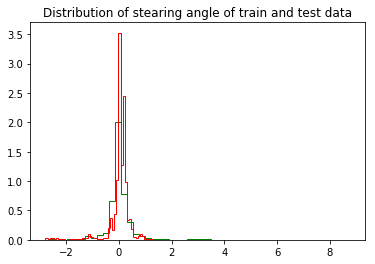

In [4]:
plt.hist(train_y, bins=50, normed=1, color='green', histtype='step')
plt.hist(test_y, bins=50, normed=1, color='red', histtype='step')
plt.title("Distribution of stearing angle of train and test data")
plt.show()

In [5]:
train_mean_y = np.mean(train_y)
print("Train MSE(MEAN):", np.mean(np.square(train_mean_y-test_y)))
print("Test MSE(ZERO):", np.mean(np.square(test_y-0.0)))

Train MSE(MEAN): 0.19112687369474946
Test MSE(ZERO): 0.19089104348993743


<li> Distribution is very similar for both train and test sets. </li>
<li> Both are mostly distributed around 0 </li>

<h1> Splitting Train & Test data </h1>

In [6]:
X, Y = [], []

with open('./dataset/data.txt') as file:
    for line in file:
        X.append('./dataset/' + line.split()[0])
        Y.append(float(line.split()[1]) * scipy.pi / 180.0)

num_images = len(X)
X_train = X[:int(num_images * 0.8)]
Y_train = Y[:int(num_images * 0.8)]
X_test = X[int(num_images * 0.8):]
Y_test = Y[int(num_images * 0.8):]

num_train_X = len(X_train)
num_test_X = len(X_test)

train_batch_ptr = 0
test_batch_ptr = 0

<h1> Functions to load train and test batches </h1>

In [7]:
# Function to load batch of train images
def LoadTrainBatch(batch_size):
    global train_batch_ptr
    X_out, Y_out = [], []
    for i in range(0, batch_size):
        X_out.append(
            scipy.misc.imresize(
                scipy.misc.imread(
                    X_train[(train_batch_ptr + i) % num_train_X])[-150:], [66, 200]) / 255.0)
        Y_out.append([Y_train[(train_batch_ptr + i) % num_train_X]])
    train_batch_ptr += batch_size
    return X_out, Y_out

In [8]:
# Function to load batch of test images
def LoadTestBatch(batch_size):
    global test_batch_ptr
    X_out, Y_out = [], []
    for i in range(0, batch_size):
        X_out.append(
            scipy.misc.imresize(
                scipy.misc.imread(
                    X_test[(test_batch_ptr + i) % num_test_X])[-150:], [66, 200]) / 255.0)
        Y_out.append([Y_test[(test_batch_ptr + i) % num_test_X]])
        test_batch_ptr += batch_size
    return X_out, Y_out

<h1> Building model </h1>

In [9]:
def WeightVariable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def BiasVariable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def Conv2D(x, w, stride):
    return tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding='VALID')

<li> Defining Convolution Layers </li>

In [10]:
# Input layer
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

# First convolution layer
weight_convolution_1 = WeightVariable([5, 5, 3, 24])
bias_convolution_1 = BiasVariable([24])
h_convolution_1 = tf.nn.relu(Conv2D(x_image, weight_convolution_1, 2) + bias_convolution_1)
# Second convolution layer
weight_convolution_2 = WeightVariable([5, 5, 24, 36])
bias_convolution_2 = BiasVariable([36])
h_convolution_2 = tf.nn.relu(Conv2D(h_convolution_1, weight_convolution_2, 2) + bias_convolution_2)

# Third convolution layer
weight_convolution_3 = WeightVariable([5, 5, 36, 48])
bias_convolution_3 = BiasVariable([48])
h_convolution_3 = tf.nn.relu(Conv2D(h_convolution_2, weight_convolution_3, 2) + bias_convolution_3)

# Fourth convolution layer
weight_convolution_4 = WeightVariable([3, 3, 48, 64])
bias_convolution_4 = BiasVariable([64])
h_convolution_4 = tf.nn.relu(Conv2D(h_convolution_3, weight_convolution_4, 1) + bias_convolution_4)

# Fifth convolution layer
weight_convolution_5 = WeightVariable([3, 3, 64, 64])
bias_convolution_5 = BiasVariable([64])
h_convolution_5 = tf.nn.relu(Conv2D(h_convolution_4, weight_convolution_5, 1) + bias_convolution_5)


# Fully connected layer 1
weight_fc_1 = WeightVariable([1152, 1164])
bias_fc_1 = BiasVariable([1164])

# Flattening
h_convolution_5_flat = tf.reshape(h_convolution_5, [-1, 1152])

h_fc_1 = tf.nn.relu(tf.matmul(h_convolution_5_flat, weight_fc_1) + bias_fc_1)
keep_prob = tf.placeholder(tf.float32)
h_fc_1_drop = tf.nn.dropout(h_fc_1, keep_prob)

# Fully connected layer 2
weight_fc_2 = WeightVariable([1164, 100])
bias_fc_2 = BiasVariable([100])
h_fc_2 = tf.nn.relu(tf.matmul(h_fc_1_drop, weight_fc_2) + bias_fc_2)
h_fc_2_drop = tf.nn.dropout(h_fc_2, keep_prob)

# Fully connected layer 3
weight_fc_3 = WeightVariable([100, 50])
bias_fc_3 = BiasVariable([50])
h_fc_3 = tf.nn.relu(tf.matmul(h_fc_2_drop, weight_fc_3) + bias_fc_3)
h_fc_3_drop = tf.nn.dropout(h_fc_3, keep_prob)

# Fully connected layer 4
weight_fc_4 = WeightVariable([50, 10])
bias_fc_4 = BiasVariable([10])
h_fc_4 = tf.nn.relu(tf.matmul(h_fc_3_drop, weight_fc_4) + bias_fc_4)
h_fc_4_drop = tf.nn.dropout(h_fc_4, keep_prob)

# Output layer
weight_fc_5 = WeightVariable([10, 1])
bias_fc_5 = BiasVariable([1])
y = tf.multiply(tf.atan(tf.matmul(h_fc_4_drop, weight_fc_5) + bias_fc_5), 2)


<h1> Training the Model </h1>

In [11]:
%%time

LOG_DIR = './save/'

sess = tf.InteractiveSession()
L2NormConstant = 0.001
train_vars = tf.trainable_variables()

# Defining loss
loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n(
    [tf.nn.l2_loss(v) for v in train_vars]) * L2NormConstant

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# Creating summary to monitor cost
tf.summary.scalar("loss", loss)
merged_summary_output = tf.summary.merge_all()
saver = tf.train.Saver(write_version=saver_pb2.SaverDef.V1)

# Output to write logs
log_path = './logs/'
summary_writer = tf.summary.FileWriter(log_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100


# Training of dataset
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={x:xs, y_:ys, keep_prob:0.8})
        if i%10 == 0:
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={x:xs, y_:ys, keep_prob:1.0})
            print("Epoch:%d, Step:%d, Loss:%g"%(epoch, epoch*batch_size+i, loss_value))
            
        summary = merged_summary_output.eval(feed_dict={x:xs, y_:ys, keep_prob:1.0})
        summary_writer.add_summary(summary, epoch*num_images/batch_size+i)
        
        if i%batch_size==0:
            if not os.path.exists(LOG_DIR):
                os.makedirs(LOG_DIR)
            checkpoint_path = os.path.join(LOG_DIR, 'model.ckpt')
            file_name = saver.save(sess, checkpoint_path)
    print("Model saved in file: "+str(file_name))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:0, Step:0, Loss:6.5641
Epoch:0, Step:10, Loss:6.36689
Epoch:0, Step:20, Loss:6.4097
Epoch:0, Step:30, Loss:6.31075
Epoch:0, Step:40, Loss:6.17502
Epoch:0, Step:50, Loss:6.16587
Epoch:0, Step:60, Loss:6.20027
Epoch:0, Step:70, Loss:6.04557
Epoch:0, Step:80, Loss:5.96073
Epoch:0, Step:90, Loss:5.88442
Epoch:0, Step:100, Loss:5.87478
Epoch:0, Step:110, Loss:5.79784
Epoch:0, Step:120, Loss:5.80184
Epoch:0, Step:130, Loss:5.69769
Epoch:0, Step:140, Loss:5.65572
Epoch:0, Step:150, Loss:5.64529
Epoch:0, Step:160, Loss:5.69336
Epoch:0, Step:170, Loss:5.54546
Epoch:0, Step:180, Loss:5.46766
Epoch:0, Step:190, Loss:5.40697
Epoch:0, Step:200, Loss:5.37581
Epoch:0, Step:210, Loss:5.32912
Epoch:0, Step:220, Loss:5.3581
Epoch:0, Step:230, Loss:5.25035
Epoch:0, Step:240, Loss:5.17704
Epoch:0, Step:250, Loss:5.17435
Epoch:0, Step:260, Loss:5.2119
Epoch:0, Step:270, Loss:5.12472
Epoch:0, Step:280, Loss:5.04688
Epoch:0, Step

Epoch:2, Step:310, Loss:3.09941
Epoch:2, Step:320, Loss:3.09681
Epoch:2, Step:330, Loss:3.12721
Epoch:2, Step:340, Loss:3.03469
Epoch:2, Step:350, Loss:3.0488
Epoch:2, Step:360, Loss:3.06538
Epoch:2, Step:370, Loss:3.09376
Epoch:2, Step:380, Loss:3.03453
Epoch:2, Step:390, Loss:3.00073
Epoch:2, Step:400, Loss:2.94993
Epoch:2, Step:410, Loss:2.91875
Epoch:2, Step:420, Loss:2.93657
Epoch:2, Step:430, Loss:3.00992
Epoch:2, Step:440, Loss:2.90016
Epoch:2, Step:450, Loss:2.87923
Epoch:2, Step:460, Loss:2.91593
Epoch:2, Step:470, Loss:2.94603
Epoch:2, Step:480, Loss:2.90443
Epoch:2, Step:490, Loss:2.88101
Epoch:2, Step:500, Loss:2.77716
Epoch:2, Step:510, Loss:2.76889
Epoch:2, Step:520, Loss:2.7716
Epoch:2, Step:530, Loss:2.83512
Epoch:2, Step:540, Loss:2.73601
Epoch:2, Step:550, Loss:2.71551
Epoch:2, Step:560, Loss:2.75367
Epoch:2, Step:570, Loss:2.78573
Epoch:2, Step:580, Loss:2.75628
Epoch:2, Step:590, Loss:2.7465
Epoch:2, Step:600, Loss:2.63672
Epoch:2, Step:610, Loss:2.61877
Epoch:2, St

Epoch:4, Step:630, Loss:1.89953
Epoch:4, Step:640, Loss:1.91296
Epoch:4, Step:650, Loss:1.8581
Epoch:4, Step:660, Loss:1.94643
Epoch:4, Step:670, Loss:1.89378
Epoch:4, Step:680, Loss:1.89723
Epoch:4, Step:690, Loss:1.86693
Epoch:4, Step:700, Loss:1.8797
Epoch:4, Step:710, Loss:1.79479
Epoch:4, Step:720, Loss:1.79271
Epoch:4, Step:730, Loss:1.80734
Epoch:4, Step:740, Loss:1.81715
Epoch:4, Step:750, Loss:1.7865
Epoch:4, Step:760, Loss:1.86119
Epoch:4, Step:770, Loss:1.82631
Epoch:4, Step:780, Loss:1.89686
Epoch:4, Step:790, Loss:1.88183
Epoch:4, Step:800, Loss:1.84514
Epoch:4, Step:810, Loss:1.6943
Epoch:4, Step:820, Loss:1.74965
Epoch:4, Step:830, Loss:1.74753
Epoch:4, Step:840, Loss:1.77385
Epoch:4, Step:850, Loss:1.73645
Model saved in file: ./save/model.ckpt
Epoch:5, Step:500, Loss:1.78726
Epoch:5, Step:510, Loss:1.74223
Epoch:5, Step:520, Loss:1.7442
Epoch:5, Step:530, Loss:1.79751
Epoch:5, Step:540, Loss:1.7706
Epoch:5, Step:550, Loss:1.67338
Epoch:5, Step:560, Loss:1.65187
Epoch:5

Epoch:6, Step:1010, Loss:1.24098
Epoch:6, Step:1020, Loss:1.14293
Epoch:6, Step:1030, Loss:1.22552
Epoch:6, Step:1040, Loss:1.21186
Epoch:6, Step:1050, Loss:1.22002
Model saved in file: ./save/model.ckpt
Epoch:7, Step:700, Loss:1.21447
Epoch:7, Step:710, Loss:1.22439
Epoch:7, Step:720, Loss:1.24294
Epoch:7, Step:730, Loss:1.24364
Epoch:7, Step:740, Loss:1.24949
Epoch:7, Step:750, Loss:1.19392
Epoch:7, Step:760, Loss:1.1644
Epoch:7, Step:770, Loss:1.18155
Epoch:7, Step:780, Loss:1.17675
Epoch:7, Step:790, Loss:1.20541
Epoch:7, Step:800, Loss:1.19442
Epoch:7, Step:810, Loss:1.2449
Epoch:7, Step:820, Loss:1.24775
Epoch:7, Step:830, Loss:1.23203
Epoch:7, Step:840, Loss:1.16084
Epoch:7, Step:850, Loss:1.20888
Epoch:7, Step:860, Loss:1.12948
Epoch:7, Step:870, Loss:1.1402
Epoch:7, Step:880, Loss:1.1186
Epoch:7, Step:890, Loss:1.14974
Epoch:7, Step:900, Loss:1.16035
Epoch:7, Step:910, Loss:1.09777
Epoch:7, Step:920, Loss:1.13646
Epoch:7, Step:930, Loss:1.16884
Epoch:7, Step:940, Loss:1.15622


Epoch:9, Step:950, Loss:0.874124
Epoch:9, Step:960, Loss:0.829924
Epoch:9, Step:970, Loss:0.877755
Epoch:9, Step:980, Loss:0.884413
Epoch:9, Step:990, Loss:0.861037
Epoch:9, Step:1000, Loss:0.83711
Epoch:9, Step:1010, Loss:0.844194
Epoch:9, Step:1020, Loss:0.844619
Epoch:9, Step:1030, Loss:0.878625
Epoch:9, Step:1040, Loss:0.953988
Epoch:9, Step:1050, Loss:0.778488
Epoch:9, Step:1060, Loss:0.813773
Epoch:9, Step:1070, Loss:0.831666
Epoch:9, Step:1080, Loss:0.824227
Epoch:9, Step:1090, Loss:0.853222
Epoch:9, Step:1100, Loss:0.809216
Epoch:9, Step:1110, Loss:0.832807
Epoch:9, Step:1120, Loss:0.825634
Epoch:9, Step:1130, Loss:0.914933
Epoch:9, Step:1140, Loss:0.949171
Epoch:9, Step:1150, Loss:0.856819
Epoch:9, Step:1160, Loss:0.820823
Epoch:9, Step:1170, Loss:0.838064
Epoch:9, Step:1180, Loss:0.808547
Epoch:9, Step:1190, Loss:0.878081
Epoch:9, Step:1200, Loss:0.889318
Epoch:9, Step:1210, Loss:0.826307
Epoch:9, Step:1220, Loss:0.804935
Epoch:9, Step:1230, Loss:0.823171
Epoch:9, Step:1240, 

Epoch:11, Step:1290, Loss:0.637771
Epoch:11, Step:1300, Loss:0.627242
Epoch:11, Step:1310, Loss:0.681234
Epoch:11, Step:1320, Loss:0.648868
Epoch:11, Step:1330, Loss:0.634719
Epoch:11, Step:1340, Loss:0.708732
Epoch:11, Step:1350, Loss:0.657939
Epoch:11, Step:1360, Loss:0.635757
Epoch:11, Step:1370, Loss:0.606773
Epoch:11, Step:1380, Loss:0.592665
Epoch:11, Step:1390, Loss:0.597587
Epoch:11, Step:1400, Loss:0.621582
Epoch:11, Step:1410, Loss:0.690236
Epoch:11, Step:1420, Loss:0.629099
Epoch:11, Step:1430, Loss:0.581909
Epoch:11, Step:1440, Loss:0.653583
Epoch:11, Step:1450, Loss:0.636285
Epoch:11, Step:1460, Loss:0.640458
Epoch:11, Step:1470, Loss:0.601839
Epoch:11, Step:1480, Loss:0.583528
Epoch:11, Step:1490, Loss:0.568219
Epoch:11, Step:1500, Loss:0.578001
Epoch:11, Step:1510, Loss:0.689464
Epoch:11, Step:1520, Loss:0.566699
Epoch:11, Step:1530, Loss:0.590104
Epoch:11, Step:1540, Loss:0.642858
Epoch:11, Step:1550, Loss:0.663602
Model saved in file: ./save/model.ckpt
Epoch:12, Step:1

Epoch:13, Step:1610, Loss:0.737065
Epoch:13, Step:1620, Loss:0.767149
Epoch:13, Step:1630, Loss:0.521336
Epoch:13, Step:1640, Loss:0.525588
Epoch:13, Step:1650, Loss:0.58005
Epoch:13, Step:1660, Loss:0.608158
Epoch:13, Step:1670, Loss:0.56663
Epoch:13, Step:1680, Loss:0.550182
Epoch:13, Step:1690, Loss:0.480128
Epoch:13, Step:1700, Loss:0.48988
Epoch:13, Step:1710, Loss:0.572762
Epoch:13, Step:1720, Loss:0.504915
Epoch:13, Step:1730, Loss:0.494584
Epoch:13, Step:1740, Loss:0.48968
Epoch:13, Step:1750, Loss:0.557476
Model saved in file: ./save/model.ckpt
Epoch:14, Step:1400, Loss:0.563646
Epoch:14, Step:1410, Loss:0.560693
Epoch:14, Step:1420, Loss:0.557242
Epoch:14, Step:1430, Loss:0.468166
Epoch:14, Step:1440, Loss:0.464852
Epoch:14, Step:1450, Loss:0.553673
Epoch:14, Step:1460, Loss:0.481844
Epoch:14, Step:1470, Loss:0.476874
Epoch:14, Step:1480, Loss:0.491836
Epoch:14, Step:1490, Loss:0.603709
Epoch:14, Step:1500, Loss:0.552975
Epoch:14, Step:1510, Loss:0.611737
Epoch:14, Step:1520,

Epoch:15, Step:1910, Loss:0.424959
Epoch:15, Step:1920, Loss:0.467814
Epoch:15, Step:1930, Loss:0.413957
Epoch:15, Step:1940, Loss:0.456948
Epoch:15, Step:1950, Loss:0.612812
Model saved in file: ./save/model.ckpt
Epoch:16, Step:1600, Loss:0.51691
Epoch:16, Step:1610, Loss:0.657274
Epoch:16, Step:1620, Loss:1.01763
Epoch:16, Step:1630, Loss:0.70483
Epoch:16, Step:1640, Loss:0.62394
Epoch:16, Step:1650, Loss:0.664876
Epoch:16, Step:1660, Loss:0.47243
Epoch:16, Step:1670, Loss:0.439166
Epoch:16, Step:1680, Loss:0.548838
Epoch:16, Step:1690, Loss:0.564562
Epoch:16, Step:1700, Loss:0.478397
Epoch:16, Step:1710, Loss:0.453636
Epoch:16, Step:1720, Loss:0.520791
Epoch:16, Step:1730, Loss:0.418863
Epoch:16, Step:1740, Loss:0.430046
Epoch:16, Step:1750, Loss:0.443092
Epoch:16, Step:1760, Loss:0.425178
Epoch:16, Step:1770, Loss:0.41503
Epoch:16, Step:1780, Loss:0.490379
Epoch:16, Step:1790, Loss:0.42415
Epoch:16, Step:1800, Loss:0.42664
Epoch:16, Step:1810, Loss:0.447833
Epoch:16, Step:1820, Los

Epoch:18, Step:1810, Loss:0.44092
Epoch:18, Step:1820, Loss:0.446999
Epoch:18, Step:1830, Loss:0.416465
Epoch:18, Step:1840, Loss:0.391309
Epoch:18, Step:1850, Loss:0.397038
Epoch:18, Step:1860, Loss:0.430686
Epoch:18, Step:1870, Loss:0.415343
Epoch:18, Step:1880, Loss:0.399348
Epoch:18, Step:1890, Loss:0.452544
Epoch:18, Step:1900, Loss:0.458043
Epoch:18, Step:1910, Loss:0.444783
Epoch:18, Step:1920, Loss:0.474752
Epoch:18, Step:1930, Loss:0.389836
Epoch:18, Step:1940, Loss:0.39144
Epoch:18, Step:1950, Loss:0.387515
Epoch:18, Step:1960, Loss:0.40635
Epoch:18, Step:1970, Loss:0.435295
Epoch:18, Step:1980, Loss:0.456947
Epoch:18, Step:1990, Loss:0.525633
Epoch:18, Step:2000, Loss:1.4072
Epoch:18, Step:2010, Loss:1.34423
Epoch:18, Step:2020, Loss:0.725002
Epoch:18, Step:2030, Loss:0.868075
Epoch:18, Step:2040, Loss:0.556108
Epoch:18, Step:2050, Loss:0.404966
Epoch:18, Step:2060, Loss:0.420563
Epoch:18, Step:2070, Loss:0.464125
Epoch:18, Step:2080, Loss:0.473559
Epoch:18, Step:2090, Loss:

Epoch:20, Step:2110, Loss:0.386808
Epoch:20, Step:2120, Loss:0.450535
Epoch:20, Step:2130, Loss:0.421649
Epoch:20, Step:2140, Loss:0.390692
Epoch:20, Step:2150, Loss:0.360071
Epoch:20, Step:2160, Loss:0.375112
Epoch:20, Step:2170, Loss:0.360043
Epoch:20, Step:2180, Loss:0.366546
Epoch:20, Step:2190, Loss:0.351662
Epoch:20, Step:2200, Loss:0.36079
Epoch:20, Step:2210, Loss:0.372204
Epoch:20, Step:2220, Loss:0.485841
Epoch:20, Step:2230, Loss:0.386062
Epoch:20, Step:2240, Loss:0.377567
Epoch:20, Step:2250, Loss:0.352014
Epoch:20, Step:2260, Loss:0.382673
Epoch:20, Step:2270, Loss:0.350661
Epoch:20, Step:2280, Loss:0.422027
Epoch:20, Step:2290, Loss:0.378377
Epoch:20, Step:2300, Loss:0.424779
Epoch:20, Step:2310, Loss:0.372375
Epoch:20, Step:2320, Loss:0.476648
Epoch:20, Step:2330, Loss:0.412329
Epoch:20, Step:2340, Loss:0.435977
Epoch:20, Step:2350, Loss:0.340857
Epoch:20, Step:2360, Loss:0.332655
Epoch:20, Step:2370, Loss:0.430687
Epoch:20, Step:2380, Loss:0.630694
Epoch:20, Step:2390, 

Epoch:22, Step:2430, Loss:0.89726
Epoch:22, Step:2440, Loss:0.493788
Epoch:22, Step:2450, Loss:0.381617
Epoch:22, Step:2460, Loss:0.576466
Epoch:22, Step:2470, Loss:0.671311
Epoch:22, Step:2480, Loss:0.494406
Epoch:22, Step:2490, Loss:0.422485
Epoch:22, Step:2500, Loss:0.340351
Epoch:22, Step:2510, Loss:0.326234
Epoch:22, Step:2520, Loss:0.352163
Epoch:22, Step:2530, Loss:0.455781
Epoch:22, Step:2540, Loss:0.391056
Epoch:22, Step:2550, Loss:0.356279
Epoch:22, Step:2560, Loss:0.346441
Epoch:22, Step:2570, Loss:0.274701
Epoch:22, Step:2580, Loss:0.363811
Epoch:22, Step:2590, Loss:0.422934
Epoch:22, Step:2600, Loss:0.346284
Epoch:22, Step:2610, Loss:0.328267
Epoch:22, Step:2620, Loss:0.330549
Epoch:22, Step:2630, Loss:0.414812
Epoch:22, Step:2640, Loss:0.420352
Epoch:22, Step:2650, Loss:0.416953
Model saved in file: ./save/model.ckpt
Epoch:23, Step:2300, Loss:0.385953
Epoch:23, Step:2310, Loss:0.375118
Epoch:23, Step:2320, Loss:0.381784
Epoch:23, Step:2330, Loss:0.435012
Epoch:23, Step:23

Epoch:24, Step:2750, Loss:0.41101
Epoch:24, Step:2760, Loss:0.476217
Epoch:24, Step:2770, Loss:0.418375
Epoch:24, Step:2780, Loss:0.614623
Epoch:24, Step:2790, Loss:0.90135
Epoch:24, Step:2800, Loss:0.664625
Epoch:24, Step:2810, Loss:0.636297
Epoch:24, Step:2820, Loss:0.823079
Epoch:24, Step:2830, Loss:0.602875
Epoch:24, Step:2840, Loss:0.710387
Epoch:24, Step:2850, Loss:0.756901
Model saved in file: ./save/model.ckpt
Epoch:25, Step:2500, Loss:0.835435
Epoch:25, Step:2510, Loss:0.428376
Epoch:25, Step:2520, Loss:0.332363
Epoch:25, Step:2530, Loss:0.326442
Epoch:25, Step:2540, Loss:0.409659
Epoch:25, Step:2550, Loss:0.33376
Epoch:25, Step:2560, Loss:0.391248
Epoch:25, Step:2570, Loss:0.376101
Epoch:25, Step:2580, Loss:0.407386
Epoch:25, Step:2590, Loss:0.425937
Epoch:25, Step:2600, Loss:0.288103
Epoch:25, Step:2610, Loss:0.334798
Epoch:25, Step:2620, Loss:0.310774
Epoch:25, Step:2630, Loss:0.399985
Epoch:25, Step:2640, Loss:0.430168
Epoch:25, Step:2650, Loss:0.324894
Epoch:25, Step:2660

Epoch:27, Step:2700, Loss:0.394416
Epoch:27, Step:2710, Loss:0.382057
Epoch:27, Step:2720, Loss:0.326964
Epoch:27, Step:2730, Loss:0.307763
Epoch:27, Step:2740, Loss:0.306754
Epoch:27, Step:2750, Loss:0.346612
Epoch:27, Step:2760, Loss:0.316395
Epoch:27, Step:2770, Loss:0.465778
Epoch:27, Step:2780, Loss:0.356078
Epoch:27, Step:2790, Loss:0.418165
Epoch:27, Step:2800, Loss:0.558285
Epoch:27, Step:2810, Loss:0.715252
Epoch:27, Step:2820, Loss:1.04115
Epoch:27, Step:2830, Loss:1.01144
Epoch:27, Step:2840, Loss:0.718715
Epoch:27, Step:2850, Loss:0.360753
Epoch:27, Step:2860, Loss:0.365869
Epoch:27, Step:2870, Loss:0.694383
Epoch:27, Step:2880, Loss:0.625608
Epoch:27, Step:2890, Loss:0.410772
Epoch:27, Step:2900, Loss:0.465643
Epoch:27, Step:2910, Loss:0.457664
Epoch:27, Step:2920, Loss:0.349465
Epoch:27, Step:2930, Loss:0.384659
Epoch:27, Step:2940, Loss:0.338928
Epoch:27, Step:2950, Loss:0.373468
Epoch:27, Step:2960, Loss:0.355265
Epoch:27, Step:2970, Loss:0.544973
Epoch:27, Step:2980, L

Epoch:29, Step:3010, Loss:0.421668
Epoch:29, Step:3020, Loss:0.354608
Epoch:29, Step:3030, Loss:0.332788
Epoch:29, Step:3040, Loss:0.349349
Epoch:29, Step:3050, Loss:0.383063
Epoch:29, Step:3060, Loss:0.401854
Epoch:29, Step:3070, Loss:0.565537
Epoch:29, Step:3080, Loss:0.4499
Epoch:29, Step:3090, Loss:0.489567
Epoch:29, Step:3100, Loss:0.417642
Epoch:29, Step:3110, Loss:0.384027
Epoch:29, Step:3120, Loss:0.366534
Epoch:29, Step:3130, Loss:0.32296
Epoch:29, Step:3140, Loss:0.328056
Epoch:29, Step:3150, Loss:0.346897
Epoch:29, Step:3160, Loss:0.3669
Epoch:29, Step:3170, Loss:0.40994
Epoch:29, Step:3180, Loss:0.497147
Epoch:29, Step:3190, Loss:0.789765
Epoch:29, Step:3200, Loss:1.20296
Epoch:29, Step:3210, Loss:0.994384
Epoch:29, Step:3220, Loss:0.717244
Epoch:29, Step:3230, Loss:0.639449
Epoch:29, Step:3240, Loss:0.355014
Epoch:29, Step:3250, Loss:0.644156
Epoch:29, Step:3260, Loss:0.802055
Epoch:29, Step:3270, Loss:0.512006
Epoch:29, Step:3280, Loss:0.533899
Epoch:29, Step:3290, Loss:0

<h1> Running model on test data </h1>

In [12]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg', 0)
rows, cols = img.shape
smooth_angle = 0
xs, ys = [], []

with open("./dataset/data.txt") as file:
    for line in file:
        xs.append('./dataset/'+line.split()[0])
        ys.append(float(line.split()[1])*scipy.pi/180)
        
num_img = len(xs)
start_point = math.ceil(num_images*0.8)
print("Starting frame of images:"+str(start_point))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread('./dataset/'+str(start_point)+'.jpg', mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66,200])/255
    degree = y.eval(feed_dict={x:[image], keep_prob:1.0})[0][0]*180/scipy.pi
    
    print("Steering angle:"+"(predicted)"+str(degree)+"\t"+str(ys[start_point]*180/scipy.pi)+"(actual)")
    cv2.imshow('fname', cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    
    smooth_angle += 0.2*pow(abs(degree-smooth_angle), 2.0/3.0)*(degree-smooth_angle)/abs(degree-smooth_angle)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -smooth_angle, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    cv2.imshow("Streeing Wheel", dst)
    start_point += 1
    
cv2.destroyAllWindows()

INFO:tensorflow:Restoring parameters from ./save/model.ckpt
Starting frame of images:36325
Steering angle:(predicted)-5.878619594564445	-10.79(actual)
Steering angle:(predicted)-2.937373011765701	-10.08(actual)
Steering angle:(predicted)-1.1957701826174179	-9.380000000000003(actual)
Steering angle:(predicted)1.30668220945467	-7.559999999999999(actual)
Steering angle:(predicted)1.12285695273218	-5.949999999999999(actual)
Steering angle:(predicted)1.0061762975323232	-3.23(actual)
Steering angle:(predicted)0.9742633058524963	-0.81(actual)
Steering angle:(predicted)1.5444123863239587	1.21(actual)
Steering angle:(predicted)1.6019877860976985	3.4300000000000006(actual)
Steering angle:(predicted)1.577836984244474	4.44(actual)
Steering angle:(predicted)1.6728973159568898	5.340000000000001(actual)
Steering angle:(predicted)1.9503788736305354	5.75(actual)
Steering angle:(predicted)1.7386112062918173	7.16(actual)
Steering angle:(predicted)1.818768812287206	8.27(actual)
Steering angle:(predicted)2

Steering angle:(predicted)44.64353367945612	47.19(actual)
Steering angle:(predicted)44.65495375574838	47.09(actual)
Steering angle:(predicted)45.62750097657191	47.09(actual)
Steering angle:(predicted)45.98467205883939	47.39(actual)
Steering angle:(predicted)48.345069322779906	47.7(actual)
Steering angle:(predicted)48.58886609501434	0.0(actual)
Steering angle:(predicted)50.00260255508567	47.7(actual)
Steering angle:(predicted)50.32431812537161	47.7(actual)
Steering angle:(predicted)50.39190626230347	47.7(actual)
Steering angle:(predicted)50.3948842247816	47.7(actual)
Steering angle:(predicted)51.81781411947577	47.7(actual)
Steering angle:(predicted)51.85931093377818	47.8(actual)
Steering angle:(predicted)51.97629499878758	47.7(actual)
Steering angle:(predicted)52.60062210025093	47.7(actual)
Steering angle:(predicted)52.255987830205015	47.7(actual)
Steering angle:(predicted)51.86566983989547	47.7(actual)
Steering angle:(predicted)51.120919673175614	47.7(actual)
Steering angle:(predicted)

Steering angle:(predicted)20.61226099048037	21.98(actual)
Steering angle:(predicted)21.105327224021714	21.68(actual)
Steering angle:(predicted)20.85419824371327	21.68(actual)
Steering angle:(predicted)20.394468455963466	21.68(actual)
Steering angle:(predicted)19.04626595343111	21.68(actual)
Steering angle:(predicted)18.98337698664822	21.68(actual)
Steering angle:(predicted)20.324481215085637	21.68(actual)
Steering angle:(predicted)20.04666327059537	21.68(actual)
Steering angle:(predicted)20.27274253212279	21.68(actual)
Steering angle:(predicted)22.053857792176185	21.68(actual)
Steering angle:(predicted)22.855441962979715	21.68(actual)
Steering angle:(predicted)22.872775275545912	21.68(actual)
Steering angle:(predicted)22.331578406470783	22.08(actual)
Steering angle:(predicted)21.581043069523933	22.39(actual)
Steering angle:(predicted)22.10440119203428	22.89(actual)
Steering angle:(predicted)21.37694335674561	23.5(actual)
Steering angle:(predicted)21.452375965939233	23.9(actual)
Steerin

Steering angle:(predicted)16.651442828526438	15.030000000000001(actual)
Steering angle:(predicted)16.976225153749716	15.030000000000001(actual)
Steering angle:(predicted)17.920859098982696	15.030000000000001(actual)
Steering angle:(predicted)16.33514359825232	15.030000000000001(actual)
Steering angle:(predicted)13.664569514854952	15.030000000000001(actual)
Steering angle:(predicted)12.416714444061132	15.030000000000001(actual)
Steering angle:(predicted)12.718193871383617	15.030000000000001(actual)
Steering angle:(predicted)13.752278535308024	15.030000000000001(actual)
Steering angle:(predicted)13.852311778344738	15.030000000000001(actual)
Steering angle:(predicted)13.884384639139824	15.030000000000001(actual)
Steering angle:(predicted)13.1309276887755	15.030000000000001(actual)
Steering angle:(predicted)14.027916795679412	15.230000000000002(actual)
Steering angle:(predicted)13.821619469535639	15.43(actual)
Steering angle:(predicted)14.140967525500525	15.63(actual)
Steering angle:(predi

Steering angle:(predicted)-0.025350834073884124	-0.5(actual)
Steering angle:(predicted)-0.11767526147710017	-0.5(actual)
Steering angle:(predicted)0.12137722400724708	-0.5(actual)
Steering angle:(predicted)0.07428058840034975	-0.3(actual)
Steering angle:(predicted)0.19030896053447027	-0.3(actual)
Steering angle:(predicted)-0.21067395661744343	-0.3(actual)
Steering angle:(predicted)-0.08919317920505528	-0.3(actual)
Steering angle:(predicted)-0.18342211547890078	-0.3(actual)
Steering angle:(predicted)-0.3711193690892742	-0.3(actual)
Steering angle:(predicted)-0.4427785655707274	-0.3(actual)
Steering angle:(predicted)-1.3007121972332558	-0.4(actual)
Steering angle:(predicted)-0.8196007157301392	-0.5(actual)
Steering angle:(predicted)-0.33793766977111755	-0.5(actual)
Steering angle:(predicted)-0.6721735370946469	-0.61(actual)
Steering angle:(predicted)-0.39163394898311327	-0.71(actual)
Steering angle:(predicted)-0.2893693151610676	-0.91(actual)
Steering angle:(predicted)0.01386549745853744

Steering angle:(predicted)-59.009788164540346	-60.29999999999999(actual)
Steering angle:(predicted)-60.205528891966964	-60.29999999999999(actual)
Steering angle:(predicted)-59.36644698262007	-60.610000000000014(actual)
Steering angle:(predicted)-59.58738311170247	-61.11(actual)
Steering angle:(predicted)-59.520112578567016	-61.82(actual)
Steering angle:(predicted)-58.88341600451677	-62.71999999999999(actual)
Steering angle:(predicted)-58.84458637908524	-63.13(actual)
Steering angle:(predicted)-58.53975503642758	-63.73000000000001(actual)
Steering angle:(predicted)-58.62651209926508	-63.93000000000001(actual)
Steering angle:(predicted)-59.39572800359191	-64.33999999999999(actual)
Steering angle:(predicted)-57.334472534730445	-65.04000000000002(actual)
Steering angle:(predicted)-59.41490034459214	-65.95(actual)
Steering angle:(predicted)-60.07950507159106	-66.76(actual)
Steering angle:(predicted)-59.51828891805862	-67.65999999999998(actual)
Steering angle:(predicted)-60.92922841566484	-6

Steering angle:(predicted)-10.206156162585062	-22.49(actual)
Steering angle:(predicted)-9.149060591346883	-21.38(actual)
Steering angle:(predicted)-8.089685444473211	-20.370000000000005(actual)
Steering angle:(predicted)-6.739646047940946	-18.55(actual)
Steering angle:(predicted)-5.413769299371248	-17.65(actual)
Steering angle:(predicted)-4.450177310323251	-16.24(actual)
Steering angle:(predicted)-3.9025096907831793	-15.13(actual)
Steering angle:(predicted)-3.1063777184846155	-14.32(actual)
Steering angle:(predicted)-2.3508224059412166	-13.610000000000001(actual)
Steering angle:(predicted)-1.8836549690720925	-12.709999999999999(actual)
Steering angle:(predicted)-1.7894892854192423	-11.8(actual)
Steering angle:(predicted)-1.455171589227805	-10.69(actual)
Steering angle:(predicted)-0.49008112070893006	-9.08(actual)
Steering angle:(predicted)-0.432611562186899	-8.07(actual)
Steering angle:(predicted)-0.1214991001952495	-7.16(actual)
Steering angle:(predicted)0.3275343311698361	-5.94999999

Steering angle:(predicted)10.018953484039706	18.05(actual)
Steering angle:(predicted)10.296077310555573	17.65(actual)
Steering angle:(predicted)10.496138673987124	17.55(actual)
Steering angle:(predicted)15.28875520231178	17.34(actual)
Steering angle:(predicted)15.518217115025651	16.74(actual)
Steering angle:(predicted)15.03830411827846	16.24(actual)
Steering angle:(predicted)16.026816906286896	16.24(actual)
Steering angle:(predicted)15.564805835354308	16.24(actual)
Steering angle:(predicted)13.059587216668364	16.24(actual)
Steering angle:(predicted)13.549181152790402	16.24(actual)
Steering angle:(predicted)13.484115063209568	16.03(actual)
Steering angle:(predicted)16.721983314727037	15.83(actual)
Steering angle:(predicted)19.768172552471853	15.63(actual)
Steering angle:(predicted)22.073825850214718	15.63(actual)
Steering angle:(predicted)21.071247995157936	15.33(actual)
Steering angle:(predicted)16.748648373246766	14.52(actual)
Steering angle:(predicted)13.482810497078095	13.41(actual)

Steering angle:(predicted)0.7422564539817081	2.42(actual)
Steering angle:(predicted)0.5427566601659791	1.21(actual)
Steering angle:(predicted)0.7460075618573674	0.3(actual)
Steering angle:(predicted)-0.30133081734718464	-0.2(actual)
Steering angle:(predicted)-0.5197305983699851	-0.2(actual)
Steering angle:(predicted)-0.019197367240231543	-0.2(actual)
Steering angle:(predicted)0.7331853224336965	-0.3(actual)
Steering angle:(predicted)0.5522797047771223	-0.81(actual)
Steering angle:(predicted)1.105442104782763	-1.82(actual)
Steering angle:(predicted)1.126443549098377	-2.52(actual)
Steering angle:(predicted)0.3762641557207334	-3.23(actual)
Steering angle:(predicted)-0.8342177474407896	-3.63(actual)
Steering angle:(predicted)-1.1911432630632632	-3.63(actual)
Steering angle:(predicted)-2.036864223005118	-3.63(actual)
Steering angle:(predicted)-1.696749510477338	-3.63(actual)
Steering angle:(predicted)-2.5242037698142283	-3.63(actual)
Steering angle:(predicted)-2.187377686650104	-3.63(actual

Steering angle:(predicted)0.11113947080259216	-0.71(actual)
Steering angle:(predicted)0.2680338585867841	-0.81(actual)
Steering angle:(predicted)0.3922232662424384	-0.91(actual)
Steering angle:(predicted)0.3888499532052455	-1.11(actual)
Steering angle:(predicted)0.1796677659314284	-1.6100000000000003(actual)
Steering angle:(predicted)0.15809161188996804	-2.12(actual)
Steering angle:(predicted)0.07213751649665907	-2.32(actual)
Steering angle:(predicted)-0.22211202885734213	-2.52(actual)
Steering angle:(predicted)-0.2736297845490079	-2.52(actual)
Steering angle:(predicted)-0.4350332644540652	-2.52(actual)
Steering angle:(predicted)-0.2834032783231937	-2.52(actual)
Steering angle:(predicted)-0.4351404130466698	-2.62(actual)
Steering angle:(predicted)-0.9884898428416924	-2.62(actual)
Steering angle:(predicted)-1.6037939442463438	-2.62(actual)
Steering angle:(predicted)-1.7247869034117116	-2.62(actual)
Steering angle:(predicted)-1.0195428710163323	-2.62(actual)
Steering angle:(predicted)0.0

Steering angle:(predicted)-6.9137765981885435	-7.659999999999998(actual)
Steering angle:(predicted)-6.237294599109794	-7.659999999999998(actual)
Steering angle:(predicted)-7.162857802406453	-7.659999999999998(actual)
Steering angle:(predicted)-8.153771401908148	-7.760000000000002(actual)
Steering angle:(predicted)-7.913814049760907	-7.87(actual)
Steering angle:(predicted)-8.446592710683996	-7.969999999999999(actual)
Steering angle:(predicted)-7.397055597536082	-8.17(actual)
Steering angle:(predicted)-5.141339947249296	-8.27(actual)
Steering angle:(predicted)-3.5011097185452846	-8.37(actual)
Steering angle:(predicted)-2.7613453764761324	-8.37(actual)
Steering angle:(predicted)-3.730222864724662	-8.469999999999999(actual)
Steering angle:(predicted)-4.35582721156281	-8.570000000000002(actual)
Steering angle:(predicted)-4.410447807468579	-8.67(actual)
Steering angle:(predicted)-4.185405454034529	-8.77(actual)
Steering angle:(predicted)-4.696507228966114	-8.77(actual)
Steering angle:(predic

Steering angle:(predicted)-13.695611870859013	-18.05(actual)
Steering angle:(predicted)-14.260446317104265	-17.95(actual)
Steering angle:(predicted)-14.37794947649058	-17.75(actual)
Steering angle:(predicted)-14.096679725148515	-17.239999999999995(actual)
Steering angle:(predicted)-13.477613576893361	-16.64(actual)
Steering angle:(predicted)-12.86958501433695	-15.929999999999998(actual)
Steering angle:(predicted)-12.68784051071208	-15.33(actual)
Steering angle:(predicted)-11.074821328774576	-14.72(actual)
Steering angle:(predicted)-10.054554991314752	-14.12(actual)
Steering angle:(predicted)-10.274656983544766	-13.21(actual)
Steering angle:(predicted)-9.18403969763381	-12.100000000000001(actual)
Steering angle:(predicted)-8.317310890073994	-11.19(actual)
Steering angle:(predicted)-6.125683331656262	-10.08(actual)
Steering angle:(predicted)-3.6817460239773196	-8.97(actual)
Steering angle:(predicted)-2.496380140456535	-7.760000000000002(actual)
Steering angle:(predicted)-1.79560913491557

Steering angle:(predicted)1.1054603541944517	-5.75(actual)
Steering angle:(predicted)1.1204712957211413	-5.949999999999999(actual)
Steering angle:(predicted)1.448600840524547	-6.150000000000001(actual)
Steering angle:(predicted)1.5024475973416946	-6.25(actual)
Steering angle:(predicted)1.7313670436250783	0.0(actual)
Steering angle:(predicted)1.8626743354891058	-6.25(actual)
Steering angle:(predicted)1.878107361362161	-6.25(actual)
Steering angle:(predicted)1.240836304369691	-6.45(actual)
Steering angle:(predicted)1.579190002030371	-6.45(actual)
Steering angle:(predicted)2.002098560129753	-6.45(actual)
Steering angle:(predicted)1.7547123100430646	-6.150000000000001(actual)
Steering angle:(predicted)1.786313460898598	-6.150000000000001(actual)
Steering angle:(predicted)1.7031270928931317	-6.050000000000001(actual)
Steering angle:(predicted)1.2421834524617703	-5.949999999999999(actual)
Steering angle:(predicted)0.8365641308641005	-5.849999999999999(actual)
Steering angle:(predicted)0.6255

Steering angle:(predicted)5.317391915087783	5.45(actual)
Steering angle:(predicted)8.207279103866028	3.9300000000000006(actual)
Steering angle:(predicted)9.535986538959873	2.12(actual)
Steering angle:(predicted)7.2271794013677555	0.5(actual)
Steering angle:(predicted)5.8396029927043935	-1.51(actual)
Steering angle:(predicted)1.049666780020439	-2.92(actual)
Steering angle:(predicted)1.0365338203503853	-3.63(actual)
Steering angle:(predicted)2.3077108922303307	-3.829999999999999(actual)
Steering angle:(predicted)3.9214177888398902	-4.24(actual)
Steering angle:(predicted)6.281856887689073	-4.54(actual)
Steering angle:(predicted)6.7299369340357735	-5.139999999999999(actual)
Steering angle:(predicted)6.725616412498917	-5.949999999999999(actual)
Steering angle:(predicted)5.007715406987637	-6.659999999999999(actual)
Steering angle:(predicted)3.287575593532472	-7.659999999999998(actual)
Steering angle:(predicted)1.055036696090244	-8.37(actual)
Steering angle:(predicted)-1.322644254823284	-8.87

Steering angle:(predicted)12.76364451144182	17.140000000000004(actual)
Steering angle:(predicted)13.328945971871573	17.55(actual)
Steering angle:(predicted)13.222159379293007	17.850000000000005(actual)
Steering angle:(predicted)13.513650508727995	18.149999999999995(actual)
Steering angle:(predicted)13.511300069879866	18.25(actual)
Steering angle:(predicted)13.776460820064454	18.25(actual)
Steering angle:(predicted)13.700324701386322	18.25(actual)
Steering angle:(predicted)13.705618951766727	18.35(actual)
Steering angle:(predicted)13.121268093741811	18.55(actual)
Steering angle:(predicted)13.449840320180797	18.760000000000005(actual)
Steering angle:(predicted)13.363604913041156	19.16(actual)
Steering angle:(predicted)13.958673191647469	19.66(actual)
Steering angle:(predicted)13.78424467439733	20.07(actual)
Steering angle:(predicted)13.845287782557026	0.0(actual)
Steering angle:(predicted)13.624155285535986	20.77(actual)
Steering angle:(predicted)14.178711150854015	21.18(actual)
Steering

<li> The model is working better and giving very less error. </li>
<li> Steering angle of test data is very close to actual angle. </li>
<li> Visualization makes far sense to understand the significance of model and it is very satisfying to see the car in running mode and turning the steering automatically. </li>